<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/11wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-y4jDwHKvjCIA0zPHvUsYxx&si=X5fHH0vOTVR_-iXZ >}}

# 2. Imports 

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

# 3. `torch.nn.Embedding`

## A. 임베딩레이어 

`-` 모티브: `torch.nn.functional.one_hot` + `torch.nn.Linear` 를 매번 쓰는건 너무 귀찮지 않어? 

In [5]:
torch.manual_seed(43052)
#x = ['옥순','영숙','하니','옥순','영숙']
x = torch.tensor([0,1,2,0,1])
E = torch.nn.functional.one_hot(x).float()
linr = torch.nn.Linear(3,1,bias=False) 
lf = linr(E)
lf

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<MmBackward0>)

`-` 코드를 뜯어보면.. 

In [11]:
linr.weight

Parameter containing:
tensor([[-0.2002, -0.4890,  0.2081]], requires_grad=True)

In [13]:
E @ linr.weight.T

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<MmBackward0>)

-   ${\boldsymbol x}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow {\bf E}= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}$

- $\text{linr}({\bf E})= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

`-` `torch.nn.functional.one_hot` + `torch.nn.Linear` 를 함께처리해주는 레이어 `torch.nn.Embedding` 존재 

In [20]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(3,1) 
ebdd.weight.data = linr.weight.data.T
ebdd(x)

tensor([[-0.2002],
        [-0.4890],
        [ 0.2081],
        [-0.2002],
        [-0.4890]], grad_fn=<EmbeddingBackward0>)

- $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \end{bmatrix} = \begin{bmatrix} -0.2002 \\ -0.4890 \\ 0.2081 \\ -0.2002 \\ -0.4890 \end{bmatrix}$

- 우리가 이전에 구현했던 코드 "onehot + linr" 와 "ebdd"는 정확하게 동일한 동작을 수행함. 

`-` 결론: 아래의 두개의 코드는 같다. 

```Python 
X = torch.tensor([0,1,2,0,1])

## 코드1 
linr = torch.nn.Linear(3,1) 
linr(torch.nn.functional.one_hot(X))

## 코드2 
ebdd = torch.nn.Embedding(3,1)
ebdd(X) 
```

`# 의문`: 그냥 원핫인코딩없이 바로 선형변환하면 안되나? (= 꼭 임베딩레이어를 써야하나?)

In [23]:
x = torch.tensor([0,1,2,0,1])
X = x.reshape(-1,1).float()
x,X

(tensor([0, 1, 2, 0, 1]),
 tensor([[0.],
         [1.],
         [2.],
         [0.],
         [1.]]))

In [25]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(1,1)
l1(X)

tensor([[-0.8470],
        [-1.1937],
        [-1.5404],
        [-0.8470],
        [-1.1937]], grad_fn=<AddmmBackward0>)

In [26]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(3,1) 
ebdd(x)

tensor([[-0.8178],
        [-0.7052],
        [-0.5843],
        [-0.8178],
        [-0.7052]], grad_fn=<EmbeddingBackward0>)

결과적으로 0,1,2 를 다른숫자들로 맵핑한건 비슷해보이는데? 

`-` 수식의 차이: 비슷해보이지만 계산방식이 조금 다름 

In [27]:
l1.weight, l1.bias

(Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

- $l_1({\bf X}) = \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \times (-0.3467) + (-0.8470)=\begin{bmatrix} -0.8470 \\ -1.1937 \\ -1.5404 \\ -0.8470 \\ -1.1937 \end{bmatrix}$

- $\text{ebdd}({\boldsymbol x})= \text{linr}\big(\text{onehot}({\boldsymbol x})\big) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \\ -0.8178 \\ -0.7052 \end{bmatrix}$

`-` 데이터를 읽으며 해석: 사실상 0,1,2에 대한 의미는 "옥순","영숙","하니" 같은 자료였고, 임베딩의 결과는 "옥순","영숙","하니"가 가지는 어떠한 특징이었음 (예를들면 매력같은). 데이터를 상상하며 위의 결과를 다시 해석해보자. 

**옥순이 가지는 어떠한 특징 (-0.8470 혹은 -0.8178) 을 바꾸고 싶다면?**

- `ebdd`의 경우: `ebdd.weigth`에 있는 -0.8178 이라는 숫자를 조정하면 된다. 이 조정은 옥순의 특징만 바꾸며 영숙과 하니의 특징은 바꾸지 않는다. (개별조정이 쉬움)
- `linr`의 경우: `linr.weight`에 있는 -0.3467 혹은 `linr.bias`에 있는 -0.8470 을 조정하면 되는데, 이를 조정하면 옥순의 특징을 바꿈과 동시에 영숙/하니의 특징까지 같이 바뀌게 된다. (개별조정이 어려움) 

**만약에 출연자가 1000명이라면??**

- `linr`의 경우: 1000명의 특징을 단 2개의 파라메터로 조정해야한다. (그리고 한명의 특징을 바꾸면 999명의 특징이 같이 바뀐다, 개별조정은 애초에 가능하지 않음.) 
- `ebdd`의 경우: 1000개의 특징을 조정할 수 있는 1000개의 파라메터를 확보할 수 있게 된다. 

`-` 결론: ebdd가 더 파라메터 미세조정을 통하여 특징을 학습하기 용이하다. (독립적으로 특징값을 줄 수 있으니까!)

> 만약에 문자열이 "최우수(A)", "우수(B)", "보통(C)", "미흡(D)", "매우미흡(F)" 이었다면 특징을 뽑아낼때 linr 가 더 적절했겠죠? 

## B. MF-based 추천시스템 재설계

아래의 자료를 활용하여 추천시스템을 설계하고자한다. 

In [115]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [116]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

임베딩레이어를 활용하여 MF-based 추천시스템을 설계하라. 

(풀이)

In [30]:
torch.manual_seed(43052)
ebdd1 = torch.nn.Embedding(9,2)
b1 = torch.nn.Embedding(9,1)
ebdd2 = torch.nn.Embedding(8,2)
b2 = torch.nn.Embedding(8,1)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(ebdd1.parameters())+list(b1.parameters())+list(ebdd2.parameters())+list(b2.parameters()) 
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    # 1
    W_feature = ebdd1(X1)
    W_bias = b1(X1)
    M_feature = ebdd2(X2)
    M_bias = b2(X2)
    score = (W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score)*5 
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [32]:
torch.concat([yhat,y],axis=1)[::4]

tensor([[4.1083, 4.0200],
        [0.9388, 1.1200],
        [4.0483, 3.9900],
        [0.9707, 0.9600],
        [4.2264, 4.0500],
        [0.9518, 0.9900],
        [0.5124, 0.5600],
        [1.1198, 1.1200],
        [4.0588, 4.1600],
        [1.0596, 1.0500],
        [3.9666, 3.7800],
        [0.9472, 0.8800],
        [3.9194, 4.0400],
        [1.0346, 1.0300],
        [4.8851, 4.8500],
        [4.5387, 4.3900]], grad_fn=<SliceBackward0>)

# 4. 사용자정의 네트워크 

## A. 사용자정의 네트워크 사용법

`# 예비학습1`: `net(x)`와 사실 `net.forward(x)`는 같다.

In [33]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)

In [34]:
X = torch.randn(5,1)
X

tensor([[ 0.3837],
        [ 0.7194],
        [-0.2655],
        [-1.2488],
        [ 0.5538]])

In [35]:
net(X)

tensor([[0.3901],
        [0.3808],
        [0.4083],
        [0.4362],
        [0.3854]], grad_fn=<SigmoidBackward0>)

In [36]:
net.forward(X)

tensor([[0.3901],
        [0.3808],
        [0.4083],
        [0.4362],
        [0.3854]], grad_fn=<SigmoidBackward0>)

그래서 `net.forward`를 재정의하면 `net(x)`의 기능을 재정의 할 수 있다.

In [38]:
net.forward = lambda x: '메롱'

-   `lambda x: '메롱'` 은 입력이 x 출력이 '메롱'인 함수를 의미 (즉 입력값에 상관없이 항상 '메롱'을 출력하는 함수)
-   `net.forward = lambda x:1` 이라고 새롭게 선언하였므로 앞으론 `net.forward(x)`, `net(x)` 도 입력값에 상관없이 항상 '메롱'을 출력하게 될것임

In [39]:
net.forward(X)

'메롱'

In [41]:
net(X)

'메롱'

`#`

`# 예비학습2`: `torch.nn.Module`을 상속받아서 네트워크를 만들면 (= “`class XXX(torch.nn.Module):`” 와 같은 방식으로 클래스를 선언하면) 약속된 아키텍처를 가진 네트워크를 찍어내는 함수를 만들 수 있다.

(예시1)

In [44]:
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.Sigmoid()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이제

``` python
net = Mynet1()
```

는 아래와 같은 효과를 가진다.

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False)
)
```

(예시2)

In [45]:
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.a1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(in_features=1,out_features=1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

이제

``` python
net = Mynet2()
```

는 아래와 같은 효과를 가진다.

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1,bias=True),
    torch.nn.RuLU(),
    torch.nn.Linear(in_features=1,out_features=1,bias=False)
)
```

***클래스에 대한 이해가 부족한 학생을 위한 암기방법***

**step1:** 아래와 코드를 복사하여 틀을 만든다. (이건 무조건 고정임, XXXX 자리는 원하는 이름을 넣는다)

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return yhat
```

- `forward`의 입력: `X`는 `net(X)`에 사용하는 `X`임
- `forward`의 출력: `yhat`은 `net.forward(X)` 함수의 리턴값임
-  사실, `X`/`yhat`은 다른 변수로 써도 무방하나 (예를들면 `input`/`output` 이라든지, `netin`/`netout` 이라든지) 설명의 편의상 `X`와 `yhat`을 고정한다.

**step2:** `def __init__(self):`에 yhat을 구하기 위해 필요한 재료를 레이어를 정의하고 이름을 붙인다. 이름은 항상 `self.xxx` 와 같은 식으로 정의한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        
        ## 정의 끝
        return yhat
```

**step3:** `def forward:`에 "X –\> yhat" 으로 가는 과정을 묘사한 코드를 작성하고 yhat을 리턴하도록 한다.

``` python
class XXXX(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.xxx1 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        self.xxx2 = torch.nn.Sigmoid()
        self.xxx3 = torch.nn.Linear(in_features=1,out_features=1,bias=True)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        u = self.xxx1(X) 
        v = self.xxx2(u)
        yhat = self.xxx3(v) 
        ## 정의 끝
        return yhat
```

`#`

`# 실습`: 사용자정의 네트워크를 사용하여 아래의 자료를 학습해보자. 

In [46]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

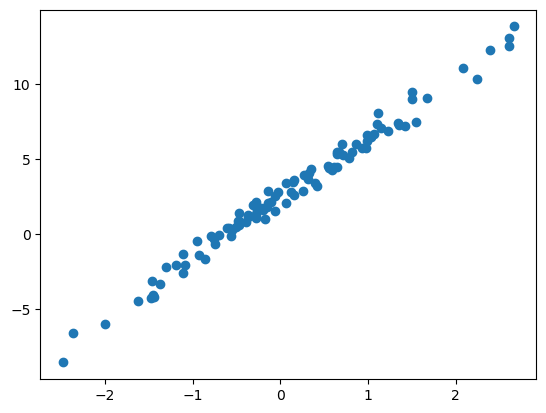

In [47]:
plt.plot(x,y,'o')

(풀이)

In [48]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레어어를 정의
        self.linr = torch.nn.Linear(1,1)
        ## 정의 끝
    def forward(self,X):
        ## yhat을 어떻게 구할것인지 정의 
        yhat = self.linr(X)
        ## 정의 끝
        return yhat

In [49]:
net = Net()

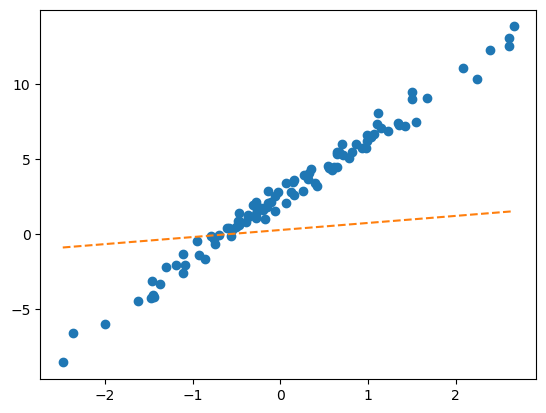

In [50]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--') # 최초의 직선

In [51]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD(net.parameters(),lr=0.1)
for epoc in range(30):
    # 1
    yhat = net(x)
    # 2 
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

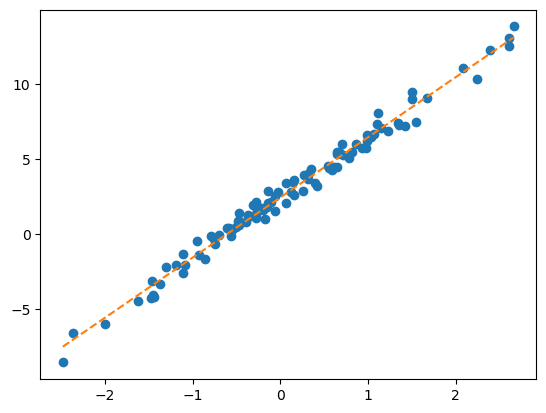

In [52]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

`#`

## B. MF-based 추천시스템 재설계

아래의 자료를 활용하여 추천시스템을 설계하고자한다. 

In [84]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [85]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

사용자정의 네트워크를 이용하여 MF-based 추천시스템을 설계하라. 

(풀이1) -- `net(X1,X2)`

In [86]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
    def forward(self,X1,X2):
        W_feature = self.ebdd1(X1)
        W_bias = self.b1(X1)
        M_feature = self.ebdd2(X2)
        M_bias = self.b2(X2)
        score = (W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias 
        yhat = sig(score) * 5 
        return yhat

In [87]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(100):
    # 1
    yhat = net(X1,X2) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [88]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[3.9088, 4.0200],
        [0.6968, 0.4300],
        [3.4267, 3.4300],
        [3.5181, 3.4200],
        [0.9098, 0.9900],
        [0.7797, 0.5200],
        [0.5975, 0.4300],
        [0.9656, 0.9400],
        [3.8616, 3.7800],
        [0.8109, 0.8900],
        [0.4865, 0.4800],
        [3.9685, 3.8200],
        [4.6336, 4.3900]])

(풀이2) -- `net(X)`

In [89]:
X = torch.stack([X1,X2],axis=1)
X[:5]

tensor([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [0, 5]])

In [90]:
X[:,0], X[:,1]

(tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8]),
 tensor([1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 6, 7, 0, 1, 3,
         4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 7, 0, 1, 2, 3, 4, 5,
         6, 7, 0, 1, 2, 4, 5, 6, 0, 1, 3, 4, 5, 6, 7]))

In [91]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.sig = torch.nn.Sigmoid()
    def forward(self,X):
        X1,X2 = X[:,0],X[:,1]
        W_feature = self.ebdd1(X1)
        W_bias = self.b1(X1)
        M_feature = self.ebdd2(X2)
        M_bias = self.b2(X2)
        score = (W_feature * M_feature).sum(axis=1).reshape(-1,1) + W_bias + M_bias 
        yhat = sig(score) * 5 
        return yhat

In [92]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(100):
    # 1
    yhat = net(X) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [93]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[4.1003, 4.0200],
        [0.5432, 0.4300],
        [3.5055, 3.4300],
        [3.3474, 3.4200],
        [0.9624, 0.9900],
        [0.6404, 0.5200],
        [0.4905, 0.4300],
        [0.7304, 0.9400],
        [4.0403, 3.7800],
        [0.8519, 0.8900],
        [0.6959, 0.4800],
        [3.8667, 3.8200],
        [4.4733, 4.3900]])

# 5. NN-based 추천시스템

## A. NN-based 방식 

아래의 자료를 활용하여 추천시스템을 설계하고자한다. 

In [2]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [3]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n int vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n int vector 
y = torch.tensor(df_train['y']).float().reshape(-1,1) # (n,1) float vector

NN-based 추천시스템을 설계하라. 

(풀이1) -- 실패

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,1),
            torch.nn.Sigmoid()
        )   
    def forward(self,X1,X2):
        W_feature = self.ebdd1(X1)
        M_feature = self.ebdd2(X2)
        W_bias = self.b1(X1)
        M_bias = self.b2(X2)
        Z = torch.concat([W_feature,M_feature,W_bias,M_bias],axis=1)
        yhat = self.mlp(Z) * 5 
        return yhat

In [9]:
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(1000):
    # 1
    yhat = net(X1,X2) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [10]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[2.1566, 4.0200],
        [1.6908, 0.4300],
        [2.6466, 3.4300],
        [2.7759, 3.4200],
        [2.5815, 0.9900],
        [2.3104, 0.5200],
        [2.6402, 0.4300],
        [1.7232, 0.9400],
        [2.3892, 3.7800],
        [2.4107, 0.8900],
        [1.9775, 0.4800],
        [2.0164, 3.8200],
        [4.7447, 4.3900]])

- 못하겠네?

(풀이2) -- 에라 모르겠다 깊은신경망.. 

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #--#
        self.ebdd1 = torch.nn.Embedding(9,2)
        self.ebdd2 = torch.nn.Embedding(8,2)
        self.b1 = torch.nn.Embedding(9,1)
        self.b2 = torch.nn.Embedding(8,1)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(6,15),
            torch.nn.ReLU(),
            torch.nn.Linear(15,15),
            torch.nn.ReLU(),
            torch.nn.Linear(15,1),
            torch.nn.Sigmoid()
        )   
    def forward(self,X1,X2):
        W_feature = self.ebdd1(X1)
        M_feature = self.ebdd2(X2)
        W_bias = self.b1(X1)
        M_bias = self.b2(X2)
        Z = torch.concat([W_feature,M_feature,W_bias,M_bias],axis=1)
        yhat = self.mlp(Z) * 5 
        return yhat

In [12]:
torch.manual_seed(43052)
net = Net()
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1) # 이게 편해요!!
#--# 
for epoc in range(1000):
    # 1
    yhat = net(X1,X2) 
    # 2
    loss = loss_fn(yhat,y)
    # 3 
    loss.backward()
    # 4 
    optimizr.step()
    optimizr.zero_grad()

In [13]:
torch.concat([yhat.data,y],axis=1)[::5]

tensor([[4.0276, 4.0200],
        [0.4426, 0.4300],
        [3.4343, 3.4300],
        [3.4210, 3.4200],
        [0.9852, 0.9900],
        [0.5153, 0.5200],
        [0.4402, 0.4300],
        [0.9483, 0.9400],
        [3.8077, 3.7800],
        [0.8960, 0.8900],
        [0.4833, 0.4800],
        [3.8466, 3.8200],
        [4.3930, 4.3900]])

- 잘 맞추긴했는데 불안함

In [16]:
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


(옥순-영식), (영자-다호), (하니-영호) 를 예측해보자. 

In [19]:
XX1 = torch.tensor([0,1,8])
XX2 = torch.tensor([1,7,2])

In [20]:
net(XX1,XX2)

tensor([[4.0114],
        [0.5262],
        [4.9767]], grad_fn=<MulBackward0>)

그럴싸함.. (오버피팅 아닌듯)

## B. NCF [@he2017neural]

![](https://github.com/guebin/DL2024/blob/main/posts/NCF.png?raw=true)

# A1. 자잘한 용어 정리 ($\star$)

## A. 지도학습 

`-` 우리가 수업에서 다루는 데이터는 주로 아래와 같은 느낌이다. 

1.  데이터는 $(X,y)$의 형태로 정리되어 있다. 

2.  $y$는 우리가 관심이 있는 변수이다. 즉 우리는 $y$를 적절하게 추정하는 것에 관심이 있다.

3.  $X$는 $y$를 추정하기 위해 필요한 정보이다.

|  $X$ = 설명변수 = 독립변수   | $y$ = 반응변수 = 종속변수  |     비고     |     순서     |           예시           |
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|
|            이미지            |          카테고리          | 합성곱신경망 |   상관없음   |  개/고양이 이미지 구분   |
|         유저,아이템          |            평점            |  추천시스템  |   상관없음   |    넷플릭스 영화추천     |
|     과거~오늘까지의주가      |          내일주가          |  순환신경망  | 순서상관있음 |         주가예측         |
| 처음 $m$개의 단어(혹은 문장) | 이후 1개의 단어(혹은 문장) |  순환신경망  | 순서상관있음 |     챗봇, 텍스트생성     |
| 처음 $m$개의 단어(혹은 문장) |          카테고리          |  순환신경망  | 순서상관있음 | 영화리뷰 텍스트 감정분류 |

`-` 이러한 문제상황, 즉 $(X,y)$가 주어졌을때 $X \to y$를 추정하는 문제를 supervised learning 이라한다. 

## B. 모델이란? 

> 모델이란 단어는 제 발작버튼이었어요.. 

`-` 통계학에서 모델은 y와 x의 관계를 의미하며 오차항의 설계를 포함하는 개념이다. 이는 통계학이 "데이터 = 정보 + 오차"의 관점을 유지하기 때문이다. 따라서 통계학에서 모델링이란 

$$y_i = net(x_i) + \epsilon_i$$

에서 (1) 적절한 함수 $net$를 선택하는 일 (2) 적절한 오차항 $\epsilon_i$ 을 설계하는일 모두를 포함한다. 

`-` 딥러닝 혹은 머신러닝에서 모델은 단순히

$$y_i \approx net(x_i)$$

를 의미하는 경우가 많다. 즉 "model=net"라고 생각해도 무방하다. 이 경우 "모델링"이란 단순히 적절한 $net$을 설계하는 것만을 의미할 경우가 많다. 

`-` 그래서 생긴일

- 통계학교재 특: 분류문제와 회귀문제를 엄밀하게 구분하지 않는다. 사실 오차항만 다를뿐이지 크게보면 같은 회귀모형이라는 관점이다. 그래서 일반화선형모형(GLM)이라는 용어를 쓴다. 
- 머신러닝/딥러닝교재 특: 회귀문제와 분류문제를 구분해서 설명한다. (표도 만듦) 이는 오차항에 대한 기술을 모호하게 하여 생기는 현상이다.

## C. 학습이란? 

`-` 학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “규칙” 혹은 “원리”를 찾는 것이다.

-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “맵핑”을 찾는 것이다.
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 "함수”을 찾는 것이다. 즉 $y\approx f(X)$가 되도록 만드는 $f$를 잘 찾는 것이다. (이 경우 "함수를 추정한다"라고 표현)
-   학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “모델” 혹은 "모형"을 찾는 것이다. 즉 $y\approx model(X)$가 되도록 만드는 $model$을 잘 찾는 것이다. (이 경우 "모형을 학습시킨다"라고 표현)
-   **학습이란 주어진 자료 $(X,y)$를 잘 분석하여 $X$에서 $y$로 가는 어떠한 “네트워크”을 찾는 것이다. 즉 $y\approx net(X)$가 되도록 만드는 $net$을 잘 찾는 것이다. (이 경우 "네트워크를 학습시킨다"라고 표현)**

`-` prediction이란 학습과정에서 찾은 “규칙” 혹은 “원리”를 $X$에 적용하여 $\hat{y}$을 구하는 과정이다. 학습과정에서 찾은 규칙 혹은 원리는 $f$,$model$,$net$ 으로 생각가능한데 이에 따르면 아래가 성립한다.

-   $\hat{y} = f(X)$
-   $\hat{y} = model(X)$
-   $\hat{y} = net(X)$

## D. $\hat{y}$를 부르는 다양한 이름

`-` $\hat{y}$는 $X$가 주어진 자료에 있는 값인지 아니면 새로운 값 인지에 따라 지칭하는 이름이 미묘하게 다르다.

1.  $X \in data$: $\hat{y}=net(X)$ 는 predicted value, fitted value 라고 부른다.

2.  $X \notin data$: $\hat{y}=net(X)$ 는 predicted value, predicted
    value with new data 라고 부른다.

## E. 다양한 코드들 


`-` 파이썬 코드..

```Python
#Python
predictor.fit(X,y) # autogluon 에서 "학습"을 의미하는 과정
model.fit(X,y) # sklearn 에서 "학습"을 의미하는 과정
learner.learn() # fastai 에서 "학습"을 의미하는 과정
learner.fine_tune(1) # fastai 에서 "부분학습"을 의미하는 과정
learner.predict(cat1) # fastai 에서 "예측"을 의미하는 과정 
model.fit(x, y, batch_size=32, epochs=10) # keras에서 "학습"을 의미하는 과정
model.predict(test_img) # keras에서 "예측"을 의미하는 과정 
```

`-` R 코드..

```r
# R
ols <- lm(y~x) # 선형회귀분석에서 학습을 의미하는 함수
ols$fitted.values # 선형회귀분석에서 yhat을 출력 
predict(ols, newdata=test) # 선형회귀분석에서 test에 대한 예측값을 출력하는 함수
ols$coef # 선형회귀분석에서 weight를 확인하는 방법
```


# A2. 참고자료들 

`-` 케라스/텐서플로우: <https://guebin.github.io/STBDA2022/>

`-` 상속: <https://guebin.github.io/PP2023/posts/03_Class/2023-06-12-15wk-1.html>

`-` sklearn/autogluon: <https://guebin.github.io/MP2023/>

`-` 리눅스관련: <https://guebin.github.io/DSTBX2024/> -- 자료 부실함.. 강의영상 없는것 많음.. 

`-` 클래스기본: <https://guebin.github.io/PP2023/> -- `10wk-2` ~ `15wk-1`